In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Keras for model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')  # Ignore unwanted warnings for cleaner output

In [2]:
# Define your dataset paths - adjust if your data location changes
train_dir = r'C:\\Brain Cancer Detection\\Training'
test_dir = r'C:\\Brain Cancer Detection\\Testing'

In [3]:
image_paths = []
image_labels = []

categories = os.listdir(train_dir)  # Each sub-folder is a class

for category in categories:
    category_path = os.path.join(train_dir, category)
    images = os.listdir(category_path)
    
    for image in images:
        image_path = os.path.join(category_path, image)
        image_paths.append(image_path)
        image_labels.append(category)

# Create dataframe for training data
train_df = pd.DataFrame(data={'filepaths': image_paths, 'labels': image_labels})
train_df

,filepaths,labels
0,C:\\Brain Cancer Detection\\Training\glioma\Tr...,glioma
1,C:\\Brain Cancer Detection\\Training\glioma\Tr...,glioma
2,C:\\Brain Cancer Detection\\Training\glioma\Tr...,glioma
3,C:\\Brain Cancer Detection\\Training\glioma\Tr...,glioma
4,C:\\Brain Cancer Detection\\Training\glioma\Tr...,glioma
...,...,...
5707,C:\\Brain Cancer Detection\\Training\pituitary...,pituitary
5708,C:\\Brain Cancer Detection\\Training\pituitary...,pituitary
5709,C:\\Brain Cancer Detection\\Training\pituitary...,pituitary
5710,C:\\Brain Cancer Detection\\Training\pituitary...,pituitary


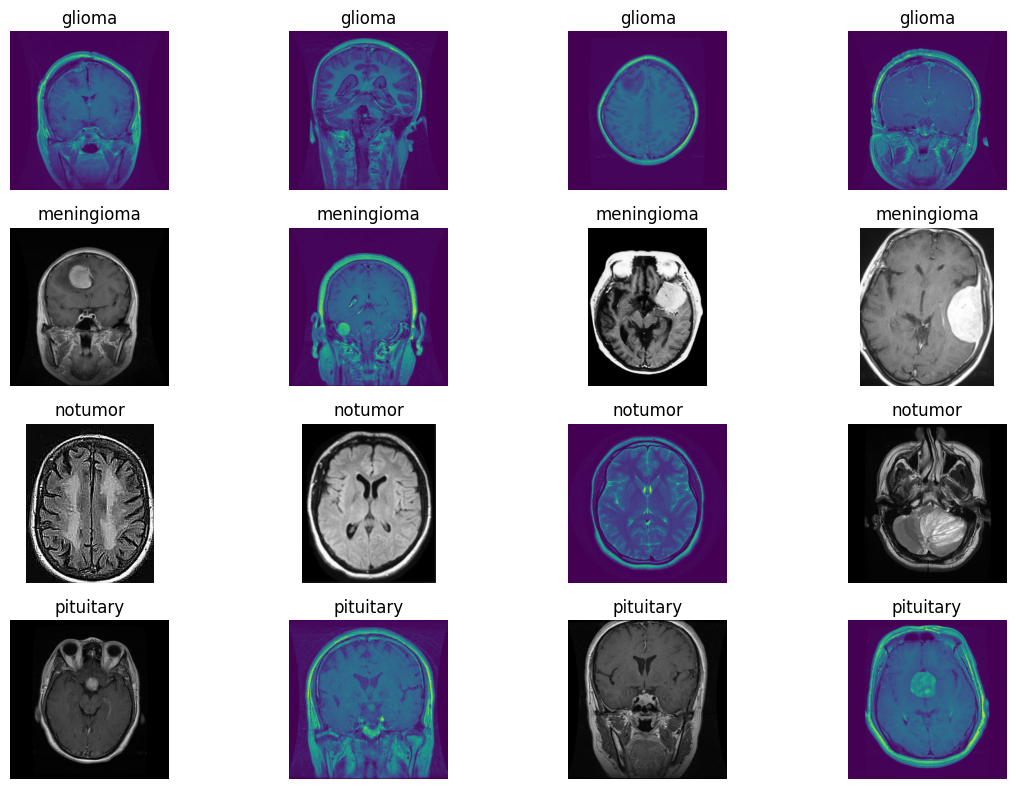

In [4]:
def plot_class_samples(df, classes, num_samples=4):
    plt.figure(figsize=(12,8))
    for i, cls in enumerate(classes):
        class_images = df[df['labels'] == cls]['filepaths'].sample(num_samples, random_state=42)
        for j, img_path in enumerate(class_images):
            img = Image.open(img_path)
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls)
    plt.tight_layout()
    plt.show()

classes = train_df['labels'].unique()
plot_class_samples(train_df, classes)


Text(0.5, 1.0, 'Train Labels Count')

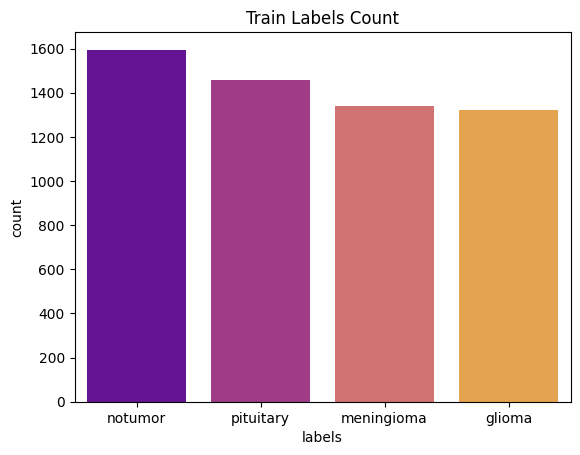

In [5]:
sns.countplot(data=train_df, x='labels', palette='plasma',
              order=train_df['labels'].value_counts().index)
plt.title('Train Labels Count')

In [6]:
sns.countplot(data=test_df,x='labels',palette='plasma',order=test_df['labels'].value_counts().index )
plt.title('Test Labels Count')

NameError: name 'test_df' is not defined

In [ ]:
# Fix: Move this after the test_df is created
# sns.countplot(data=test_df, x='labels', palette='plasma',
#               order=test_df['labels'].value_counts().index)
# plt.title('Test Labels Count')

5712

In [7]:
train_df.shape[0]  # Total training samples
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)
valid_df.shape[0]  # Validation samples

1143

In [8]:
image_paths = []
image_labels = []

categories = os.listdir(test_dir)

for category in categories:
    category_path = os.path.join(test_dir, category)
    images = os.listdir(category_path)
    
    for image in images:
        image_path = os.path.join(category_path, image)
        image_paths.append(image_path)
        image_labels.append(category)

test_df = pd.DataFrame(data={'filepaths': image_paths, 'labels': image_labels})
test_df.shape[0]


1311

In [9]:
# Define the test dataframe
image_paths = []
image_labels = []

categories = os.listdir(test_dir)

for category in categories:
	category_path = os.path.join(test_dir, category)
	images = os.listdir(category_path)

	for image in images:
		image_path = os.path.join(category_path, image)
		image_paths.append(image_path)
		image_labels.append(category)

test_df = pd.DataFrame(data={'filepaths': image_paths, 'labels': image_labels})

# Get the shape of the test dataframe
test_df.shape[0]

1311

In [10]:
# Just rescaling pixels to [0, 1]
image_gen = ImageDataGenerator(rescale=1/255)

In [11]:
gen_train = image_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels',
    target_size=(224, 224), class_mode='categorical',
    color_mode='rgb', batch_size=32)

gen_valid = image_gen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels',
    target_size=(224, 224), class_mode='categorical',
    color_mode='rgb', batch_size=32)

gen_test = image_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels',
    target_size=(224, 224), class_mode='categorical',
    color_mode='rgb', batch_size=32, shuffle=False)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [12]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer for 4-class classification
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras import metrics
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=7)

Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 859s 6s/step - accuracy: 0.6286 - loss: 0.8895 - val_accuracy: 0.8119 - val_loss: 0.5038
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 856s 6s/step - accuracy: 0.7724 - loss: 0.5942 - val_accuracy: 0.8513 - val_loss: 0.3887
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 859s 6s/step - accuracy: 0.8265 - loss: 0.4886 - val_accuracy: 0.8679 - val_loss: 0.3554
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 857s 6s/step - accuracy: 0.8461 - loss: 0.4087 - val_accuracy: 0.8950 - val_loss: 0.2792
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 855s 6s/step - accuracy: 0.8820 - loss: 0.3360 - val_accuracy: 0.9003 - val_loss: 0.2716
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 857s 6s/step - accuracy: 0.9063 - loss: 0.2756 - val_accuracy: 0.9090 - val_loss: 0.2531
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 855s 6s/step - accuracy: 0.9240 - loss: 0.2113 - val_accuracy: 0.9213 - val_loss: 0.2091
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 857s 6s/step - accuracy: 0.9236 - loss: 0.2142 - val_accu

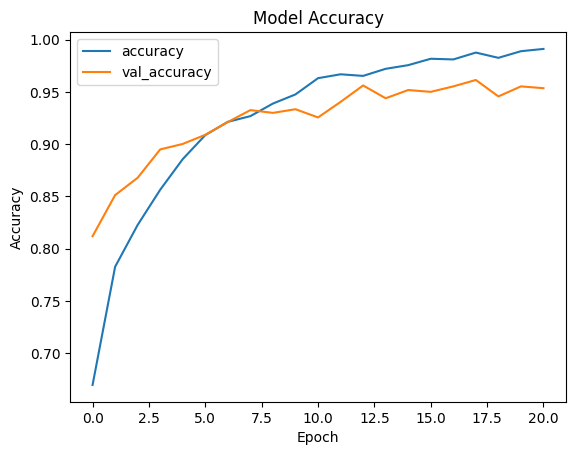

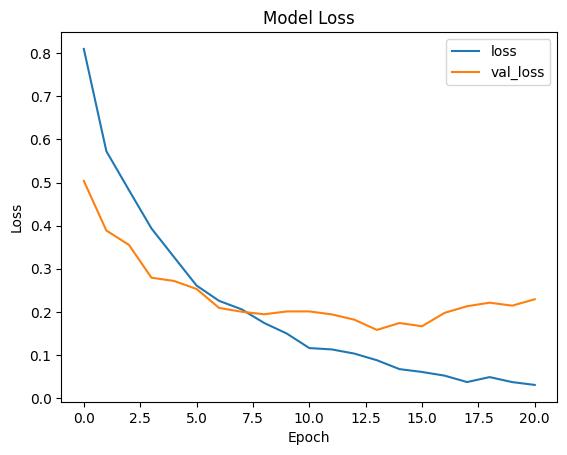

KeyError: "None of [Index(['precision', 'val_precision'], dtype='object')] are in the [columns]"

In [16]:
history = model.fit(gen_train,
                    validation_data=gen_valid,
                    epochs=25,
                    callbacks=[early_stopping])

losses = pd.DataFrame(history.history)

# Plot Accuracy
losses[['accuracy', 'val_accuracy']].plot()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot Loss
losses[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot Precision
losses[['precision', 'val_precision']].plot()
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.show()

# Plot Recall
losses[['recall', 'val_recall']].plot()
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.show()

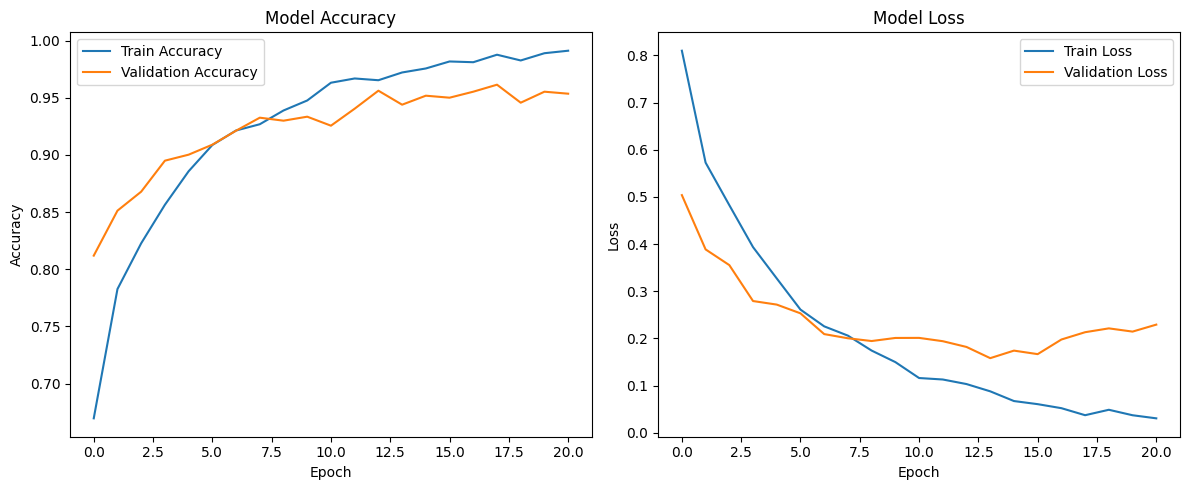


Test Accuracy: 94.97%
Test Loss: 0.2353

41/41 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step
Classification Report (Test Set):
              precision    recall  f1-score   support

      glioma       0.99      0.88      0.93       300
  meningioma       0.88      0.92      0.90       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



<Figure size 800x600 with 0 Axes>

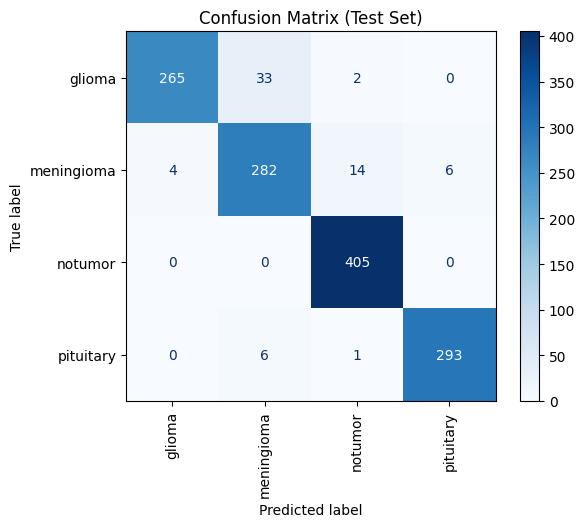

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(gen_test, verbose=0)
print(f'\nTest Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}\n')

# Detailed Classification Report
pred = model.predict(gen_test)
pred_classes = np.argmax(pred, axis=1)
true_classes = gen_test.classes
class_labels = list(gen_test.class_indices.keys())

print("Classification Report (Test Set):")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix (Test Set)')
plt.show()
